# Environment Sanity Check #

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

Check the output of `!nvidia-smi` to make sure you've been allocated a Tesla T4, P4, or P100.

In [1]:
!nvidia-smi

Sat Jun 13 01:54:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8     8W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0x1
cpu MHz		: 2000.144
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa itlb_multi

#Setup:
Set up script installs
1. Install most recent Miniconda release compatible with Google Colab's Python install  (3.6.7)
1. removes incompatible files
1. Install RAPIDS libraries
1. Set necessary environment variables
1. Copy RAPIDS .so files into current working directory, a workaround for conda/colab interactions
1. If running v0.11 or higher, updates pyarrow library to 0.15.x.

In [3]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 125 (delta 33), reused 13 (delta 1), pack-reused 0
Receiving objects: 100% (125/125), 38.25 KiB | 175.00 KiB/s, done.
Resolving deltas: 100% (33/33), done.
PLEASE READ
********************************************************************************************************
Changes:
1. Default stable version is now 0.14.  Nightly is now 0.15.  Right now, please use nightlies (0.15) as we are trying to reduce the conda solving time for stable (0.14)
2. You can now declare your RAPIDSAI version as a CLI option and skip the user prompts (ex: '0.14' or '0.15', between 0.11 to 0.15, without the quotes): 
        "!bash rapidsai-csp-utils/colab/rapids-colab.sh <version/label>"
        Examples: '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.14', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh stable',

In [4]:
# LOAD LIBRARIES
import cudf, cuml
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split, KFold
from cuml.neighbors import KNeighborsClassifier, NearestNeighbors
import matplotlib.pyplot as plt
%matplotlib inline
print('cuML version',cuml.__version__)

cuML version 0.14.0+0.g31202da.dirty


In [5]:
# LOAD TRAINING DATA
train = cudf.read_csv('sample_data/mnist_train_small.csv')
print('train shape =', train.shape )
train.head()

train shape = (19999, 785)


,6,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.571,0.572,0.573,0.574,0.575,0.576,0.577,0.578,0.579,0.580,0.581,0.582,0.583,0.584,0.585,0.586,0.587,0.588,0.589,0.590
0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


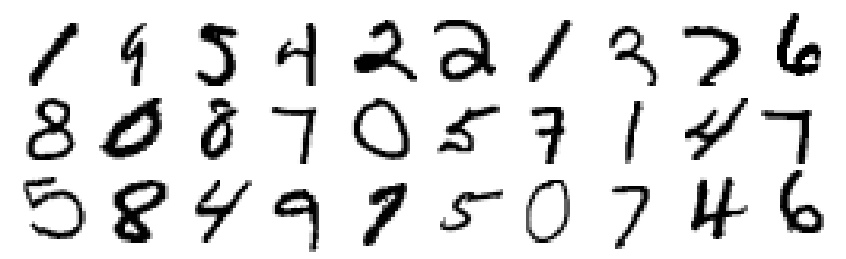

In [6]:
# VISUALIZE DATA
samples = train.iloc[5000:5030,1:].to_pandas().values
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(samples[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [7]:
# CREATE 20% VALIDATION SET
X_train, X_test, y_train, y_test = train_test_split(train.iloc[:,1:], train.iloc[:,0],\
        test_size=0.2, random_state=42)

# GRID SEARCH FOR OPTIMAL K
accs = []
for k in range(3,22):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    # Better to use knn.predict() but cuML v0.11.0 has bug
    # y_hat = knn.predict(X_test)
    y_hat_p = knn.predict_proba(X_test)
    acc = (y_hat_p.to_pandas().values.argmax(axis=1)==y_test.to_array() ).sum()/y_test.shape[0]
    #print(k,acc)
    print(k,', ',end='')
    accs.append(acc)

3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 

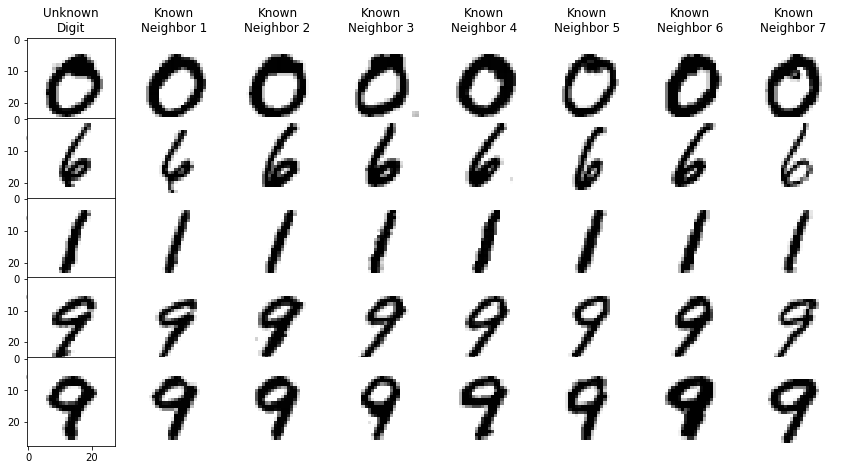

In [8]:
# COMPUTE NEIGHBORS
row = 5; col = 7; sft = 10
knn = NearestNeighbors(n_neighbors=col)
knn.fit(X_train)
distances, indicies = knn.kneighbors(X_test)
# DISPLAY NEIGHBORS
displayV = X_test.to_pandas().iloc[sft:row+sft].values
displayT = X_train.to_pandas().iloc[indicies[sft:row+sft].to_pandas().values.flatten()].values
plt.figure(figsize=(15,row*1.5))
for i in range(row):
    plt.subplot(row,col+1,(col+1)*i+1)
    plt.imshow(displayV[i].reshape((28,28)),cmap=plt.cm.binary)
    if i==0: plt.title('Unknown\nDigit')
    for j in range(col):
        plt.subplot(row, col+1, (col+1)*i+j+2)
        plt.imshow(displayT[col*i+j].reshape((28,28)),cmap=plt.cm.binary)
        if i==0: plt.title('Known\nNeighbor '+str(j+1))
        plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

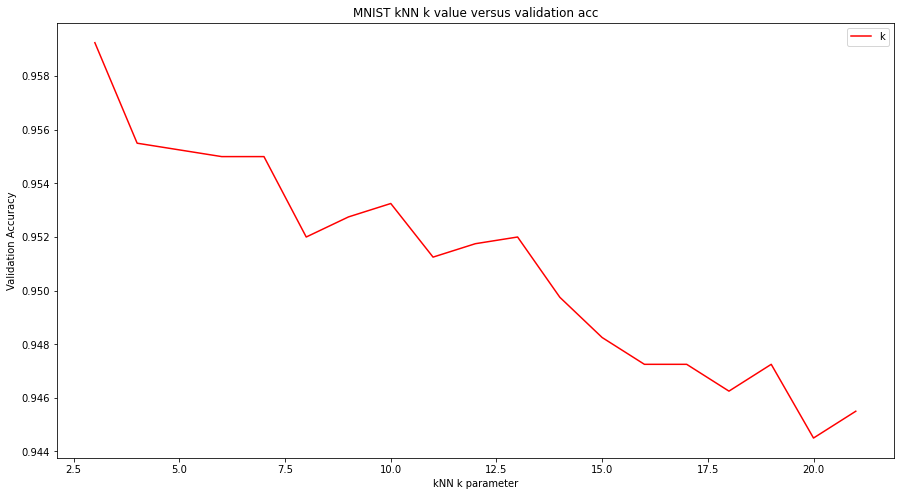

In [13]:
# PLOT GRID SEARCH RESULTS
plt.figure(figsize=(15,8))
plt.plot(range(3,22),accs, color = "red")
plt.title('MNIST kNN k value versus validation acc')
plt.xlabel("kNN k parameter")
plt.ylabel("Validation Accuracy")
plt.legend("kparameter")
plt.show()

In [14]:
# GRID SEARCH USING CROSS VALIDATION
for k in range(3,6):
    print('k =',k)
    oof = np.zeros(len(train))
    skf = KFold(n_splits=5, shuffle=True, random_state=42)
    for i, (idxT, idxV) in enumerate( skf.split(train.iloc[:,1:], train.iloc[:,0]) ):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(train.iloc[idxT,1:], train.iloc[idxT,0])
        # Better to use knn.predict() but cuML v0.11.0 has bug
        # y_hat = knn.predict(train.iloc[idxV,1:])
        y_hat_p = knn.predict_proba(train.iloc[idxV,1:])
        oof[idxV] =  y_hat_p.to_pandas().values.argmax(axis=1)
        acc = ( oof[idxV]==train.iloc[idxV,0].to_array() ).sum()/len(idxV)
        print(' fold =',i,'acc =',acc)
    acc = ( oof==train.iloc[:,0].to_array() ).sum()/len(train)
    print(' OOF with k =',k,'ACC =',acc)

k = 3
 fold = 0 acc = 0.95925
 fold = 1 acc = 0.9625
 fold = 2 acc = 0.95925
 fold = 3 acc = 0.961
 fold = 4 acc = 0.9572393098274569
 OOF with k = 3 ACC = 0.9598479923996199
k = 4
 fold = 0 acc = 0.9555
 fold = 1 acc = 0.961
 fold = 2 acc = 0.9535
 fold = 3 acc = 0.9585
 fold = 4 acc = 0.9557389347336834
 OOF with k = 4 ACC = 0.9568478423921196
k = 5
 fold = 0 acc = 0.95525
 fold = 1 acc = 0.95975
 fold = 2 acc = 0.95475
 fold = 3 acc = 0.96
 fold = 4 acc = 0.95423855963991
 OOF with k = 5 ACC = 0.9567978398919946


In [17]:
# LOAD TEST DATA
test = cudf.read_csv('sample_data/mnist_test.csv')
print('test shape =', test.shape )
test.head()

test shape = (9999, 785)


,7,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.648,0.649,0.650,0.651,0.652,0.653,0.654,0.655,0.656,0.657,0.658,0.659,0.660,0.661,0.662,0.663,0.664,0.665,0.666,0.667
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
# FIT KNN MODEL
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train.iloc[:,1:785], train.iloc[:,0])

KNeighborsClassifier(weights='uniform')

In [0]:
%%time
# PREDICT TEST DATA
# Better to use knn.predict() but cuML v0.11.0 has bug
y_hat = knn.predict(test)
#y_hat_p = knn.predict_proba(test)
y_hat_1 = y_hat.to_pandas().values.argmax(axis=1)

In [0]:
# SAVE PREDICTIONS TO CSV
sub = pd.read_csv('../input/digit-recognizer/sample_submission.csv')
sub.Label = y_hat
sub.to_csv('submission_cuML.csv',index=False)
sub.head()

In [0]:
# PLOT PREDICTION HISTOGRAM
plt.hist(sub.Label)
plt.title('Distribution of test predictions')
plt.show()

In [0]:
# TRAIN SKLEARN KNN MODEL
from sklearn.neighbors import KNeighborsClassifier as K2
knn = K2(n_neighbors=3,n_jobs=2)
knn.fit(train.iloc[:,1:].to_pandas(), train.iloc[:,0].to_pandas())

In [0]:
%%time
# PREDICT 1/28 OF ALL TEST IMAGES WITH CPU
y_hat = knn.predict(test.iloc[:1000,:].to_pandas())
print('Here we only infer 1000 out of 28,000 test images on CPU')